# Differentiable bitonic sort

[Bitonic sorts](https://en.wikipedia.org/wiki/Bitonic_sorter) allow creation of sorting networks with a sequence of fixed conditional swapping operations executed in parallel. A sorting network implements  a map from $\mathbb{R}^n \rightarrow \mathbb{R}^n$, where $n=2^k$ (sorting networks for non-power-of-2 sizes are possible but not trickier).

<img src="BitonicSort1.svg.png">

*[Image: from Wikipedia, by user Bitonic, CC0](https://en.wikipedia.org/wiki/Bitonic_sorter#/media/File:BitonicSort1.svg)*

The sorting network for $n=2^k$ elements has $\frac{k(k-1)}{2}$ "layers" where parallel compare-and-swap operations are used to rearrange a $k$ element vector into sorted order.

### Differentiable compare-and-swap

If we define the `softmax(a,b)` function (not the traditional "softmax" used for classification!) as the continuous approximation to the `max(a,b)` function:

$$\text{softmax}(a,b) = \log(e^a + e^b) \approx \max(a,b).$$

We can then fairly obviously write `softmin(a,b)` as:

$$\text{softmin}(a,b) = -\log(e^{-a} + e^{-b}) \approx \min(a,b).$$ More numerically stably we can write: 

$$\text{softmin}(a,b) = a + b - \text{softmax}(a,b).$$

These functions obviously aren't equal to max and min, but are relatively close, and differentiable. Note that we now have a differentiable compare-and-swap operation:

$$\text{high} = \text{softmax}(a,b), \text{low} = \text{softmin}(a,b), \text{where } \text{low}\leq \text{high}$$

Alternatively, we can use: 
$$\text{smoothmax}(a,b) = \frac{a (e^{\alpha a}) + b (e^{\alpha b})}{e^{\alpha a}+e^{\alpha b}}  \approx \max(a,b).$$  This has an adjustable smoothness parameter $\alpha$, with exact maximum as $\alpha \rightarrow \infty$ and pure averaging as $\alpha \rightarrow 0$.

## Differentiable sorting

For each layer in the sorting network, we can split all of the pairwise comparison-and-swaps into left-hand and right-hand sides which can be done simultaneously. We can any write function that selects the relevant elements of the vector as a multiply with a binary matrix.

For each layer, we can derive two binary matrices $L \in \mathbb{R}^{n \times \frac{n}{2}}$ and $R \in \mathbb{R}^{n \times \frac{n}{2}}$ which select the elements to be compared for the left and right hands respectively. This will result in the comparison between two $\frac{k}{2}$ length vectors. We can also derive two matrices $L' \in \mathbb{R}^{\frac{n}{2} \times n}$ and $R' \in \mathbb{R}^{\frac{n}{2} \times n}$ which put the results of the compare-and-swap operation back into the right positions.

Then, each layer $i$ of the sorting process is just:
$${\bf x}_{i+1} = L'_i[\text{softmin}(L_i{\bf x_i}, R_i{\bf x_i})] + R'_i[\text{softmax}(L_i{\bf x_i}, R_i{\bf x_i})]$$
$$ = L'_i\left(-\log\left(e^{-L_i{\bf x}_i} + e^{-R_i{\bf x}_i}\right)\right) +  R'_i\left(\log\left(e^{L_i{\bf x}_i} + e^{R_i{\bf x}_i}\right)\right)$$
which is clearly differentiable (though not very numerically stable -- the usable range of elements $x$ is quite limited in single float precision).

All that remains is to compute the matrices $L_i, R_i, L'_i, R'_i$ for each of the layers of the network. 

This process is excessively computation heavy, but easy to compute. We could also simplify this into two matrix multiplies, at the cost of a vector split and join in the middle (see the `woven` form later in this text). 

## Example

To sort four elements, we have a network like:

    0  1  2  3  
    ┕>>┙  │  │  
    │  │  ┕<<┙  
    ┕>>>>>┙  │  
    │  │  │  │  
    ┕>>┙  │  │  
    │  │  ┕>>┙  
    
This is equivalent to: 

    x[0], x[1] = cswap(x[0], x[1])
    x[3], x[2] = cswap(x[2], x[3])
    x[0], x[2] = cswap(x[0], x[2])
    x[0], x[1] = cswap(x[0], x[1])
    x[2], x[3] = cswap(x[2], x[3])
    
where `cswap(a,b) = (min(a,b), max(a,b))`

Replacing the indexing with matrix multiplies and `cswap` with a `softcswap = (softmin(a,b), softmax(a,b))` we then have the differentiable form.



# Test functions

In [112]:
from bitonic_tests import bitonic_network, pretty_bitonic_network

def neat_vec(n):
    # print a vector neatly    
    return "\t".join([f"{x:6.2f}" for x in n])

# this should match the diagram at the top of the notebook
bitonic_network(16)

 0>1	 2<3	 4>5	 6<7	 8>9	10<11	12>13	14<15	
----------------------------------------------------------------
 0>2	 1>3	 4<6	 5<7	 8>10	 9>11	12<14	13<15	
 0>1	 2>3	 4<5	 6<7	 8>9	10>11	12<13	14<15	
----------------------------------------------------------------
 0>4	 1>5	 2>6	 3>7	 8<12	 9<13	10<14	11<15	
 0>2	 1>3	 4>6	 5>7	 8<10	 9<11	12<14	13<15	
 0>1	 2>3	 4>5	 6>7	 8<9	10<11	12<13	14<15	
----------------------------------------------------------------
 0>8	 1>9	 2>10	 3>11	 4>12	 5>13	 6>14	 7>15	
 0>4	 1>5	 2>6	 3>7	 8>12	 9>13	10>14	11>15	
 0>2	 1>3	 4>6	 5>7	 8>10	 9>11	12>14	13>15	
 0>1	 2>3	 4>5	 6>7	 8>9	10>11	12>13	14>15	
----------------------------------------------------------------


In [113]:
pretty_bitonic_network(8)

 0  1  2  3  4  5  6  7 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╰──╮  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╰─────╮  │ 
 │  │  │  │  │  ╰─────╮ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╰──╮  │  │ 
 │  │  │  │  │  │  ╰──╮ 
 ╭───────────╯  │  │  │ 
 │  ╭───────────╯  │  │ 
 │  │  ╭───────────╯  │ 
 │  │  │  ╭───────────╯ 
 ╭─────╯  │  │  │  │  │ 
 │  ╭─────╯  │  │  │  │ 
 │  │  │  │  ╭─────╯  │ 
 │  │  │  │  │  ╭─────╯ 
 ╭──╯  │  │  │  │  │  │ 
 │  │  ╭──╯  │  │  │  │ 
 │  │  │  │  ╭──╯  │  │ 
 │  │  │  │  │  │  ╭──╯ 


# Vectorised functions

## Testing sorting network

In [114]:
# Test sorting
import autograd.numpy as np # we can use plain numpy as well (but can't take grad!)


from differentiable_sorting import bitonic_matrices, diff_sort, diff_argsort
from differentiable_sorting import softmax, smoothmax, softmax_smooth

matrices = bitonic_matrices(8)


# test bitonic sorting with exact maximum; this should work exactly as regular sorting
for i in range(5):
    # these should all be in sorted order
    test = np.random.randint(0, 200, 8)
    print(neat_vec(diff_sort(matrices, test, softmax=np.maximum)))

 24.00	 45.00	104.00	123.00	149.00	163.00	180.00	183.00
 16.00	 16.00	 18.00	 46.00	 75.00	 79.00	145.00	193.00
 16.00	 28.00	 39.00	 68.00	 75.00	 90.00	163.00	179.00
 14.00	 21.00	 49.00	 65.00	 76.00	 84.00	102.00	166.00
 10.00	 51.00	 88.00	 97.00	 99.00	124.00	134.00	141.00


## Differentiable sorting test

In [115]:
# Differentiable sorting 
np.set_printoptions(precision=2)
matrices = bitonic_matrices(8) 


for i in range(5):
    # note the range here is chosen to work well: small values will not work well! 
    test = np.random.randint(-200,200,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("Smoothmax sorting ", neat_vec(diff_sort(matrices, test, softmax=smoothmax)))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting    -171.00	-143.00	-106.00	-27.31	-25.69	  7.00	 58.00	 68.00
Smoothmax sorting  -171.00	-143.00	-106.00	-26.73	-26.27	  7.00	 58.00	 68.00
Exact sorting      -171.00	-143.00	-106.00	-27.00	-26.00	  7.00	 58.00	 68.00

Softmax sorting    -169.00	-79.00	 41.00	 82.00	104.00	140.00	158.00	165.00
Smoothmax sorting  -169.00	-79.00	 41.00	 82.00	104.00	140.00	158.01	164.99
Exact sorting      -169.00	-79.00	 41.00	 82.00	104.00	140.00	158.00	165.00

Softmax sorting    -162.00	-110.00	-51.00	-19.00	 30.00	 56.00	 81.00	170.00
Smoothmax sorting  -162.00	-110.00	-51.00	-19.00	 30.00	 56.00	 81.00	170.00
Exact sorting      -162.00	-110.00	-51.00	-19.00	 30.00	 56.00	 81.00	170.00

Softmax sorting    -156.00	-112.01	-106.99	-96.00	-55.01	-49.99	-16.00	  7.00
Smoothmax sorting  -156.00	-111.97	-107.03	-96.00	-54.97	-50.03	-16.00	  7.00
Exact sorting      -156.00	-112.00	-107.00	-96.00	-55.00	-50.00	-16.00	  7.00

Softmax sorting    -169.00	-151.00	-92.00	 10.00	 19.00	 53.00	 92.00

### Positive-only sorting
Slightly better accuracy can be achieved with normalised softmax *if* all elements are strictly positive:

In [116]:
for i in range(5):
    
    test = np.random.randint(1,8,8)
    print("Softmax sorting   ", neat_vec(diff_sort(matrices, test, softmax=softmax)))
    print("Posmax sorting    ", neat_vec(diff_sort(matrices, test, softmax=lambda a,b: softmax(a,b,normalize=1))))
    print("Exact sorting     ", neat_vec(diff_sort(matrices, test, softmax=np.maximum)))
    
    print()

Softmax sorting     -0.52	  0.91	  1.56	  2.96	  5.04	  6.44	  7.09	  8.52
Posmax sorting       0.13	  0.76	  1.38	  2.67	  5.03	  6.43	  7.09	  8.52
Exact sorting        1.00	  1.00	  1.00	  2.00	  6.00	  7.00	  7.00	  7.00

Softmax sorting      0.80	  3.05	  3.85	  5.29	  5.19	  6.58	  6.93	  8.32
Posmax sorting       0.88	  3.02	  3.84	  5.27	  5.19	  6.57	  6.92	  8.31
Exact sorting        1.00	  4.00	  4.00	  6.00	  6.00	  6.00	  6.00	  7.00

Softmax sorting      0.47	  2.38	  2.90	  4.28	  4.27	  5.67	  6.26	  7.77
Posmax sorting       0.66	  2.31	  2.87	  4.23	  4.26	  5.65	  6.25	  7.76
Exact sorting        1.00	  3.00	  4.00	  4.00	  4.00	  5.00	  6.00	  7.00

Softmax sorting      0.09	  1.49	  2.13	  3.59	  4.10	  5.76	  6.72	  8.13
Posmax sorting       0.44	  1.40	  2.06	  3.48	  4.06	  5.73	  6.71	  8.12
Exact sorting        1.00	  2.00	  2.00	  3.00	  4.00	  6.00	  7.00	  7.00

Softmax sorting      0.23	  2.06	  2.78	  4.23	  4.47	  5.88	  6.48	  7.88
Posmax sorting       

## Sorting complex numbers
The softmax/smoothmax functions are analytic as well as differentiable, so 
we can also "sort" complex numbers. This approximately sorts them by the real part with smoothmax.
Softmax forces the points towards the real line.

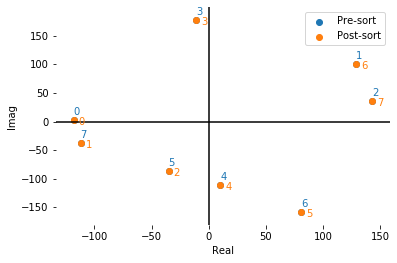

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline


test = np.random.randint(-200,200,8) + 1j * np.random.randint(-200, 200, 8)
fig, ax = plt.subplots()

def label_complex(zs, color, xyoffset, label):
    ax.scatter(np.real(zs), np.imag(zs), c=color, label=label)    
    for i, z in enumerate(zs):
        ax.annotate(str(i), (np.real(z), np.imag(z)), color=color, textcoords="offset points", xytext=xyoffset)

        
label_complex(test, 'C0', (0,5), label="Pre-sort")

smooth_sorted = diff_sort(matrices, test, softmax=smoothmax)
label_complex(smooth_sorted, 'C1', (5, -5), "Post-sort")
ax.axhline(0, c='k')
ax.axvline(0, c='k')
ax.set_xlabel("Real")
ax.set_ylabel("Imag")
ax.set_frame_on(False)
ax.legend()



# Relaxed sorting
We can define a slighly modified function which interpolates between `softmax(a,b)` and `mean(a,b)`. The result is a sorting function that can be relaxed from sorting to averaging.

In [188]:

# Differentiable smoothed sorting 
test = np.random.randint(-200,200,8)

print("Exact sorting            ", neat_vec(diff_sort(matrices, test, np.maximum)))
print()
for smooth in np.linspace(0, 1, 8):    
    print(f"Softmax.   smooth[{smooth:.2f}]  ", neat_vec(diff_sort(matrices, test, lambda a,b:softmax_smooth(a,b,smooth=smooth))))
    # smoothmax's alpha is the inverse of diff_bisort_smooth
    print(f"Smoothmax. alpha=[{1-smooth:.2f}]  ", neat_vec(diff_sort(matrices, test, lambda a,b:smoothmax(a,b, alpha=1-smooth))))
    print()
    
print(f"Mean {np.mean(test):.2f}")
print()

Exact sorting             -110.00	-67.00	-65.00	-50.00	 14.00	 95.00	141.00	151.00

Softmax.   smooth[0.00]   -110.00	-67.23	-64.77	-50.00	 14.00	 95.00	141.00	151.00
Smoothmax. alpha=[1.00]   -110.00	-66.49	-65.51	-50.00	 14.00	 95.00	141.00	151.00

Softmax.   smooth[0.14]   -58.73	-45.32	-43.86	-29.66	 29.29	 65.25	 94.76	 97.28
Smoothmax. alpha=[0.86]   -110.00	-66.37	-65.63	-50.00	 14.00	 95.00	141.00	151.00

Softmax.   smooth[0.29]   -27.06	-26.10	-23.71	-13.84	 32.30	 44.70	 60.78	 61.94
Smoothmax. alpha=[0.71]   -110.00	-66.25	-65.75	-50.00	 14.00	 95.00	141.01	150.99

Softmax.   smooth[0.43]   -11.79	-11.12	 -3.78	 -1.06	 28.79	 30.93	 37.71	 39.34
Smoothmax. alpha=[0.57]   -110.00	-66.15	-65.85	-50.00	 14.00	 95.00	141.03	150.97

Softmax.   smooth[0.57]    -0.14	  0.34	  7.05	  7.66	 22.06	 22.55	 24.25	 25.22
Smoothmax. alpha=[0.43]   -110.00	-66.05	-65.91	-50.03	 14.00	 95.00	141.14	150.86

Softmax.   smooth[0.71]     8.17	  8.48	 11.79	 12.10	 16.30	 16.61	 17.60	 17.93
Smo

## Derivatives of the sorting process

In [197]:

from autograd import jacobian

test = np.random.randint(-200,200,8)
# show that we can take the derivative
jac_sort = jacobian(diff_sort, argnum=1)
jac_sort(matrices, test, softmax=lambda a,b:softmax_smooth(a,b,0.06)) # slight relaxation

array([[0.0016, 0.0009, 0.0024, 0.0259, 0.0531, 0.0531, 0.0282, 0.8346],
       [0.026 , 0.0024, 0.0259, 0.0032, 0.8338, 0.0282, 0.0282, 0.0524],
       [0.833 , 0.0523, 0.0024, 0.0258, 0.0275, 0.0281, 0.0274, 0.0033],
       [0.0281, 0.0276, 0.0009, 0.0017, 0.0282, 0.8329, 0.0282, 0.0523],
       [0.0524, 0.8344, 0.0532, 0.029 , 0.0017, 0.0261, 0.0017, 0.0017],
       [0.004 , 0.0516, 0.8346, 0.0524, 0.0266, 0.0024, 0.0266, 0.0017],
       [0.0267, 0.0032, 0.0275, 0.0282, 0.0274, 0.0266, 0.833 , 0.0274],
       [0.0282, 0.0274, 0.0531, 0.8339, 0.0017, 0.0024, 0.0266, 0.0266]])

In [202]:
# the same, but using smoothmax
print(neat_vec(diff_sort(matrices, test, smoothmax)))
jac_sort(matrices, test,  lambda a,b:smoothmax(a,b,alpha=0.5))

-40.00	 -7.93	 -4.07	 14.00	 25.00	 41.00	141.00	195.00


array([[ 0.    , -0.    ,  0.    ,  0.    , -0.    ,  0.    ,  0.    ,
         1.    ],
       [-0.0908,  0.    , -0.    ,  0.    ,  1.091 , -0.0002, -0.    ,
        -0.    ],
       [ 1.0916, -0.    , -0.    , -0.    , -0.0909, -0.0008,  0.    ,
         0.    ],
       [-0.0009, -0.0182,  0.    , -0.    , -0.0001,  1.0192, -0.    ,
        -0.    ],
       [-0.    ,  1.023 , -0.0047, -0.    ,  0.    , -0.0182, -0.    ,
         0.    ],
       [ 0.    , -0.0047,  1.0047, -0.    , -0.    ,  0.    , -0.    ,
        -0.    ],
       [-0.    ,  0.    , -0.    , -0.    ,  0.    , -0.    ,  1.    ,
        -0.    ],
       [ 0.    , -0.    ,  0.    ,  1.    , -0.    ,  0.    , -0.    ,
         0.    ]])

## Woven form
We can "weave" the four matrices into two matrices for fewer multiplies at the cost of having to split and join the matrices at each layer.

In [208]:
from differentiable_sorting import bitonic_woven_matrices, diff_sort_weave

woven_matrices = bitonic_woven_matrices(8)

print("Exact sorting      ", neat_vec(diff_sort(matrices, test, np.maximum)))
print(f"Diff. (std.)       ", neat_vec(diff_sort(matrices, test, smoothmax)))
print(f"Diff. (woven)      ", neat_vec(diff_sort_weave(woven_matrices, test, smoothmax)))
        

Exact sorting       -40.00	 -8.00	 -4.00	 14.00	 25.00	 41.00	141.00	195.00
Diff. (std.)        -40.00	 -7.93	 -4.07	 14.00	 25.00	 41.00	141.00	195.00
Diff. (woven)       -40.00	 -7.93	 -4.07	 14.00	 25.00	 41.00	141.00	195.00


## Differentiable ranking / argsort
We can use a differentiable similarity measure between the input and output of the vector, e.g. an RBF kernel. We can use this to generate a normalised similarity matrix and apply this to a vector `[1, 2, 3, ..., n]`. This gives a differentiable ranking function.

As `sigma` gets larger, the result converges to giving all values the mean rank; as it goes to zero the result converges to the true rank.

In [209]:
from differentiable_sorting import order_matrix, diff_argsort

In [210]:
matrices = bitonic_matrices(8)

In [212]:
x = [5.0, -1.0, 9.5, 13.2, 16.2, 10.5, 42.0, 18.0]


print("x            ", neat_vec(x))
# show argsort
ranks = diff_argsort(matrices, x, sigma=0.5)
print("diff_argsort ", neat_vec(ranks))
print("exact argsort",neat_vec(np.argsort(ranks)))

x               5.00	 -1.00	  9.50	 13.20	 16.20	 10.50	 42.00	 18.00
diff_argsort    1.00	  0.00	  2.05	  4.00	  5.00	  2.97	  7.00	  6.00
exact argsort   1.00	  0.00	  2.00	  5.00	  3.00	  4.00	  7.00	  6.00


In [213]:
# we now have differentiable argmax and argmin by indexing the rank vector
print(np.argmin(x), int(ranks[0]+0.5))
print(np.argmax(x), int(ranks[-1]+0.5))

1 1
6 6


## Smoothing ranks
We can again relax argsort back to the mean rank:

In [215]:
print("Smoothed ranks")
test = x
for sigma in [0.1, 1, 10, 100, 1000]:     
    ranks = diff_argsort(matrices, test, sigma=sigma) 
    print(f"sigma={sigma:7.1f}  |", neat_vec(ranks))

Smoothed ranks
sigma=    0.1  |   1.00	  0.00	  2.00	  4.00	  5.00	  3.00	  7.00	  6.00
sigma=    1.0  |   1.00	  0.00	  2.33	  3.97	  5.12	  2.73	  7.00	  5.85
sigma=   10.0  |   2.55	  1.92	  3.01	  3.38	  3.65	  3.11	  6.79	  3.82
sigma=  100.0  |   3.47	  3.45	  3.48	  3.49	  3.49	  3.48	  3.56	  3.50
sigma= 1000.0  |   3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50	  3.50


In [216]:
np.set_printoptions(precision=4)
jac_rank = jacobian(diff_argsort, argnum=1)
print(jac_rank(matrices, np.array(test), 1.0) )

[[ 0.0008 -0.     -0.0005 -0.     -0.     -0.0002 -0.     -0.    ]
 [-0.      0.     -0.     -0.     -0.     -0.     -0.     -0.    ]
 [-0.0026 -0.      0.2329 -0.0221 -0.0017 -0.2062 -0.     -0.0002]
 [-0.0007 -0.     -0.0307  0.1461 -0.0328 -0.0764 -0.     -0.0055]
 [-0.     -0.     -0.0016 -0.0319  0.2241 -0.0023 -0.     -0.1883]
 [-0.0029 -0.     -0.2093 -0.0656 -0.004   0.2827 -0.     -0.001 ]
 [-0.     -0.     -0.     -0.     -0.     -0.      0.     -0.    ]
 [-0.     -0.     -0.0009 -0.0128 -0.1914 -0.0023 -0.      0.2075]]


In [217]:
matrices = bitonic_matrices(8)

x = [1, 2, 3, 4, 8, 7, 6, 4]
ranks = diff_argsort(matrices, x, sigma=0.25)
print("diff_argsort", neat_vec(ranks))
print("argsort     ", neat_vec(np.argsort(ranks)))

print("Jacobian of diff_argsort(x)")
print(jac_rank(matrices, np.array(x), 0.25))

diff_argsort   0.13	  1.09	  2.00	  3.11	  6.99	  6.00	  5.00	  3.11
argsort        0.00	  1.00	  2.00	  3.00	  7.00	  6.00	  5.00	  4.00
Jacobian of diff_argsort(x)
[[ 2.1616 -1.0588 -0.5227 -0.2867 -0.0101 -0.0175 -0.0556 -0.2102]
 [-0.0658  0.5622 -0.1859 -0.1551 -0.0048 -0.0106 -0.0352 -0.1049]
 [-0.0121 -0.0131  0.0406 -0.0051 -0.0003 -0.0005 -0.0019 -0.0076]
 [-0.0123 -0.0252 -0.1084  0.5644 -0.0505 -0.0863 -0.1414 -0.1404]
 [-0.0006 -0.001  -0.0029 -0.0051  0.1036 -0.0579 -0.0285 -0.0077]
 [-0.0004 -0.0008 -0.0024 -0.004  -0.0015  0.0281 -0.0125 -0.0066]
 [-0.0002 -0.0003 -0.0008 -0.0015 -0.016  -0.0177  0.038  -0.0014]
 [-0.0123 -0.0252 -0.1084 -0.2095 -0.0505 -0.0863 -0.1414  0.6334]]


In [220]:
matrices = bitonic_matrices(8)
from autograd import grad

# which elements cause the biggest change in ranking if adjusted?
# we can compute this directly:
x = [41, 2, 30, 40, 50, 60, 70, 190]

# approximate change in rank as first moment of ranks
rank_change = lambda x: np.sum((diff_argsort(matrices, x, sigma=1.0)* np.arange(1,9)))
grad_rank_change = grad(rank_change)
print("x        ", neat_vec(x))
print("d_rank/dx", neat_vec(grad_rank_change(np.array(x))))



x          41.00	  2.00	 30.00	 40.00	 50.00	 60.00	 70.00	190.00
d_rank/dx  -0.68	 -0.00	 -0.00	  0.68	 -0.00	 -0.00	 -0.00	  0.00


# PyTorch example
We can verify that this is both parallelisable on the GPU and fully differentiable.

In [81]:
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [82]:
from differentiable_sorting_torch import softmax, diff_argsort
from differentiable_sorting import diff_sort
matrices = bitonic_matrices(16)
torch_matrices = [[torch.from_numpy(matrix).float().to(device) for matrix in matrix_set] for matrix_set in matrices]


In [83]:
test_input = np.random.normal(0, 5, 16)
var_test_input = Variable(torch.from_numpy(test_input).float().to(device),
                          requires_grad=True)

result = diff_sort(torch_matrices, var_test_input, softmax=softmax)

# compute the Jacobian of the sorting function, to show we can differentiate through the
# sorting function
jac = []
for i in range(len(result)):
    jac.append(
        torch.autograd.grad(result[i], var_test_input, retain_graph=True)[0])

# 16 x 16 jacobian of the sorting matrix
print(torch.stack(jac))

tensor([[4.5973e-04, 3.3933e-02, 7.3613e-01, 5.7220e-06, 7.3584e-03, 1.8311e-02,
         1.3363e-02, 2.3068e-03, 1.7365e-01, 5.7429e-03, 7.0045e-06, 2.8817e-05,
         4.1973e-03, 3.6804e-03, 3.1447e-04, 5.0413e-04],
        [4.8785e-04, 4.3964e-02, 1.9875e-01, 7.2420e-06, 1.1447e-02, 3.0540e-02,
         2.0577e-02, 3.3834e-03, 6.5341e-01, 1.7145e-02, 2.0131e-05, 8.2905e-05,
         9.5225e-03, 8.5303e-03, 8.1938e-04, 1.3184e-03],
        [4.2167e-03, 2.7968e-01, 2.7102e-02, 5.4494e-05, 7.8724e-02, 2.0756e-01,
         1.4958e-01, 2.2536e-02, 7.6766e-02, 4.5877e-02, 7.1609e-05, 3.0935e-04,
         5.2884e-02, 4.5629e-02, 3.4320e-03, 5.5709e-03],
        [5.1660e-03, 2.5247e-01, 2.4786e-02, 6.6891e-05, 7.6780e-02, 1.9704e-01,
         1.5687e-01, 2.1487e-02, 5.0643e-02, 5.9974e-02, 7.6715e-05, 3.4016e-04,
         7.7280e-02, 6.5229e-02, 4.5771e-03, 7.2146e-03],
        [1.4384e-02, 9.4579e-02, 3.0093e-03, 1.8639e-04, 1.0764e-01, 1.2278e-01,
         1.3674e-01, 5.6585e-02, 1.1777

In [84]:
result = diff_argsort(torch_matrices, var_test_input)
print(result)


tensor([11.0000,  3.4317,  0.0000, 14.0000,  6.0228,  3.5761,  4.7984,  9.0000,
         1.0000,  5.9649, 14.0000, 13.0000,  5.9053,  7.6375, 11.0000, 10.0000],
       device='cuda:0', grad_fn=<MvBackward>)
